# CMSC828O - Jason Fan - HW2, Network generation


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

# Preamble

The GIs used in this notebook are parsed with R code taken *verbatim* from https://www.hcbravo.org/networks-across-scales/homeworks/network_stats/

In [2]:
gis_path = 'data/output/costanzo_gis_adj.tsv'
gis_df = pd.read_csv(gis_path, sep='\t')
gis_df.index = gis_df.columns
gis_df.head()

,dma3986,dma969,dma2913,dma2871,dma86,dma2378,dma955,dma2338,dma272,dma2549,...,dma4417,dma3050,dma1905,dma1565,dma5343,dma3023,dma4495,dma796,dma2289,dma1373
dma3986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma2913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma2871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
A_gi = gis_df.values
gis_df.shape

(2803, 2803)

In [4]:
'''
Helper functions for the modelling
'''
def empirical_deg_dist(A, kmin=0):
    '''
    return empirical degree distribution of given adjacency matrix
    '''
    degrees = np.sum(A, axis=0)
    k, pk = np.unique(degrees, return_counts=True)
    pk = pk / np.sum(pk[pk>= kmin])
    return k, pk

def plot_log_log(A, **kwargs):
    '''
    Plot log-log plot of A's degree distribution
    '''
    ks, pk = empirical_deg_dist(A)
    plt.scatter(np.log(ks[ks>0]), np.log(pk[ks>0]), **kwargs)
    return plt

def _empirical_cdf(A):
    '''
    Compute empirical cdf
    '''
    ks, pks = empirical_deg_dist(A)
    max_deg = max(ks)
    filled_cumsum = [np.sum(pks[ks <= k]) for k in range(max_deg + 1)]
    filled_ks = np.arange(max_deg + 1)
    return filled_ks, filled_cumsum

def empirical_cdf(A):
    '''
    return callable empirical cdf
    '''
    ks, cumsum = _empirical_cdf(A)
    def cdf(k):
        return cumsum[k] if k < len(cumsum) else 1.
    return cdf

def D(cdf1, cdf2, kmax):
    '''
    KS-statistic for two cdfs
    '''
    errs = [np.abs(cdf1(k) - cdf2(k)) for k in range(0, kmax + 1)]
    return np.max(errs)

def plot_log_cdf(A, **kwargs):
    '''
    Plot log(1-cdf(k)) of cdf of A's degree distribution
    '''
    ks, pk = empirical_deg_dist(A)
    
    max_deg = np.max(np.sum(A,axis=0))
    cdf = empirical_cdf(A)
    ks = np.arange(1, max_deg)
    cdf_pks = [1 -cdf(k) for k in ks]
    
    plt.plot(np.log(ks), np.log(cdf_pks), **kwargs)
    return plt

## Task 1

In [5]:
def ba_graph(n, m):
    'barabasi albert graph with seed of clique of size m'
    #start with m clique for nodes: n_0,..., n_(m-1)
    A = np.ones((n,n))
    A[m:] = 0
    A[:, m:] = 0
    A[np.eye(n) == 1] = 0
    
    # build network by expanding principle submatrix of desired adj matrix
    for i in range(m, n):
        degs = np.sum(A[:i][:, :i], axis=0)
        p_attach = degs / np.sum(degs)
        ixs = np.random.choice(np.arange(i), p=p_attach, size=m)
        A[i, ixs] = 1
        A[ixs, i] = 1
    return A.astype(int)

We use a simple Barabsi-Albert (BA) model parameterized by $n$ the total number of nodes and $m$ the expected number of new edges at each timestep. Where the seed graph is always a m-clique. So we generate  a graph with approximately the same number of edges with $n=2803, m=12$. (Note, we obtain $m=12$, by solving for $m_0 + tm$ where $t = n-m$ is the number of timesteps to generate $n$ total nodes.  and $m_0 = m(m-1)/2$ is the number of edges in the starting $m$ clique.

In [6]:
ba = ba_graph(len(A_gi), 12)

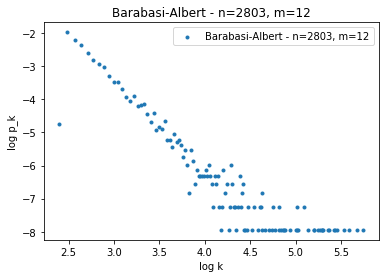

In [7]:
plot_log_log(ba, marker='.', label='Barabasi-Albert - n=2803, m=12')
plt.legend()
plt.xlabel('log k')
plt.ylabel('log p_k')
_ = plt.title('Barabasi-Albert - n=2803, m=12')

In [8]:
print("n gis", np.sum(A_gi / 2))
print("n_edges in ba", np.sum(ba / 2))

n gis 33634.0
n_edges in ba 33053.0


# Task 3
We implement the described simple node duplication model where the seed graph is a 2-clique.

In [9]:
def hector_graph(n, del_p, rw_p):
    '''
    params:
        n : size
        del_p : deletion p
        rw_p : rewiring p
    '''
    A = np.zeros((n,n))
    # start with 2-clique
    
    A[0,1] = 1
    A[1,0] = 1
    
    for i in range(2, n):
        dup_i = np.random.choice(i) # chose a node to duplicate
        A[i, :] = A[dup_i,:]
        A[:, i] = A[:, dup_i]
        
        # select uniformly at random nodes to delete
        del_edges = np.random.uniform(size=i+1) < del_p 
        
        # select uniformly at random nodes to rewire
        rewire_edges = np.random.uniform(size=i+1) < (rw_p / (i + 2)) 
        
        A[i,:i+1][del_edges] = 0
        A[:i+1, i][del_edges] = 0
        A[i,:i+1][rewire_edges] = 1
        A[:i+1, i][rewire_edges] = 1
        
    return A.astype(int)

Parameters for node duplication model were selected via trial and error to match log-log plots.

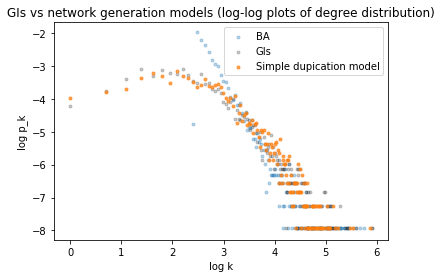

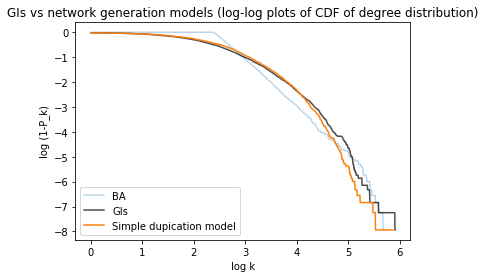

In [10]:
np.random.seed(1234)
h_A = hector_graph(2803, 0.3, 0.5)
plot_log_log(ba, marker='.',alpha=0.3, label='BA')
plot_log_log(A_gi, marker='.',alpha=0.2, color='black', label='GIs')
plot_log_log(h_A, marker='.', alpha=0.7, label='Simple dupication model')
plt.legend()
plt.xlabel('log k')
plt.ylabel('log p_k')
_ = plt.title('GIs vs network generation models (log-log plots of degree distribution)')
plt.show()

plot_log_cdf(ba, alpha=0.3, label='BA')
plot_log_cdf(A_gi,alpha=0.7, color='black', label='GIs')
plot_log_cdf(h_A, label='Simple dupication model')
plt.legend()
plt.xlabel('log k')
plt.ylabel('log (1-P_k)')
_ = plt.title('GIs vs network generation models (log-log plots of CDF of degree distribution)')

In [11]:
D(empirical_cdf(A_gi), empirical_cdf(ba.astype(int)), 2803)

0.3877987870139137

In [12]:
D(empirical_cdf(A_gi), empirical_cdf(h_A.astype(int)), 2803)

0.05315733143061008

# Task 2:
- Qualititatively, the BA model fits the GI network when the nodes in the network are in the power law regime, from the graph, the log-log plots look similar for high k.
- Quantitavely, the KS-statistic for the generated BA network vs the GI network has value ~0.4, which is much higher than the node duplication vs GI network, which is ~0.05. Futhermore, we know that the $\gamma$ coefficients for the BA model ($\gamma = 3$ and the best fitting $\gamma=2.6$ (from questions 1 and 2) are different.

# Task 4:
It is clear both *qualitatively* and *quantitatively* that the simple node duplication model is better. The plots of log PDFs and CDFs are better with this model. The model can also make sense if we believe in gene-duplication/whole genome-duplication/copy-number variation + subsequent mutation to be a driving evolutionary mechanism :).